# Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import keras
%matplotlib inline

# Data Loading and Data Exploratory

In [ ]:
solarpower = pd.read_csv("PV_Elec_Gas3.csv", header = None, skiprows=1 ,
                         names = ['date','cum_Power','Elec_kW', 'Gas_mxm'], 
                         sep=',', usecols = [0,1,2,3], parse_dates={'dt' : ['date']}, 
                         infer_datetime_format=True, index_col='dt')
print(solarpower.head(5))

            cum_Power  Elec_kW  Gas_mxm
dt                                     
2011-10-26        0.1     15.1      9.0
2011-10-27       10.2      7.4      9.2
2011-10-28       20.2      5.8      8.0
2011-10-29       29.6      4.9      6.6
2011-10-30       34.2     11.7      5.3


In [ ]:
# make solar power stationary
solarpower2 = solarpower.shift(periods=1, freq='D', axis=0)
solarpower['cum_Power_shift'] = solarpower2.loc[:,'cum_Power']
solarpower['day_Power'] = solarpower['cum_Power'].values - solarpower['cum_Power_shift']
solarpower.iloc[0:1].day_Power.value = 0.
A = solarpower.dropna()
del A['cum_Power'], A['cum_Power_shift']
solarpower = A

In [ ]:
solarpower.head(3), solarpower.tail(3)

(            Elec_kW  Gas_mxm  day_Power
 dt                                     
 2011-10-27      7.4      9.2       10.1
 2011-10-28      5.8      8.0       10.0
 2011-10-29      4.9      6.6        9.4,
             Elec_kW  Gas_mxm  day_Power
 dt                                     
 2020-11-08     12.0     11.0        8.0
 2020-11-09     14.0     10.0        5.0
 2020-11-10     14.0      9.0        3.0)

# Prepare Train/Valid Datasets

In [ ]:
X_train = solarpower[:'2019-10-28'] # use data before 2019/10/28 as training data
X_valid = solarpower['2019-10-29':'2020-10-28'] # use 365-day data as validation data
X_train.shape, X_valid.shape

((2924, 3), (366, 3))

In [ ]:
X_train.tail(3), X_valid.head(3)

(            Elec_kW  Gas_mxm  day_Power
 dt                                     
 2019-10-26      8.0      7.0        5.0
 2019-10-27      9.0      5.0        7.0
 2019-10-28     11.0      8.0        7.0,
             Elec_kW  Gas_mxm  day_Power
 dt                                     
 2019-10-29     11.0      9.0        4.0
 2019-10-30     16.0     11.0        6.0
 2019-10-31      9.0     11.0        5.0)

In [ ]:
# we devide the series into multiple input and output patterns

def split_by_window(series, window):
    '''
    the series is split in (len(series)-window)-blocks of window size, 
    y is the next value that comes after the block, 
    every block starts with the next value in the series.
    The last block ends with the last-but-one value in the series.
    '''
    X = []
    y = []
    n_steps = len(series) - window
    for step in range(n_steps):
        X.append(series[step:window+step])
        y.append(series[step + window])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [ ]:
# apply my_split_window on dayly solar power with a window of 365 days (we do not make account for leap years)
# the input series is the daily solar power
train_power_series = X_train.day_Power.values
window = 365
X, y = split_by_window(train_power_series, window)
# print a sample
for i in range(5):
    print(X[i][-10:], y[i])

[7.6 9.5 4.4 3.1 4.6 3.2 5.5 9.6 8.2 8.7] 1.5
[9.5 4.4 3.1 4.6 3.2 5.5 9.6 8.2 8.7 1.5] 2.0
[4.4 3.1 4.6 3.2 5.5 9.6 8.2 8.7 1.5 2. ] 9.200000000000273
[3.1 4.6 3.2 5.5 9.6 8.2 8.7 1.5 2.  9.2] 9.299999999999727
[4.6 3.2 5.5 9.6 8.2 8.7 1.5 2.  9.2 9.3] 1.800000000000182


# Build Model

In [ ]:
# we have an input shape = window size, number of features 
# we use only 1 feature (it is univariate) and we have a window size of one year (365 days) 
# we have to reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
def model_LSTM_cnn(window, n_features):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(32, return_sequences=True, 
                                   input_shape=(window, n_features)))
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=2, activation='relu', 
                                     input_shape=(window, n_features)))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1))
    return model

model = model_LSTM_cnn(window, n_features)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 365, 32)           4352      
_________________________________________________________________
conv1d (Conv1D)              (None, 364, 32)           2080      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 182, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 5824)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5824)              23296     
_________________________________________________________________
dense (Dense)                (None, 50)                291250    
_________________________________________________________________
dropout (Dropout)            (None, 50)                0

# Train Model

In [ ]:
epochs = 500
range1 = 2
y_hat_dict = {}
for steps in range(range1):
    # compile the model:
    model.compile(optimizer='adam', loss='mae')
    # fit model
    history = model.fit(X, y, epochs=epochs, verbose=0)
    # predicting next year
    x_input = np.array(X_train.day_Power[-365:]) #  next value based on data of last year
    x_input = x_input.reshape((1, window, n_features)) # the model expects three dimensions as input (samples, window, features)
    y_hat = model.predict(x_input, verbose=0)
    for i in range(365):
        new_x = y_hat.reshape((1,1,1))
        x_input = np.concatenate((x_input[:, -364:], new_x), axis=1)
        y_hat = model.predict(x_input, verbose=0)
    name = '108B_y_hat_15000e' + str(steps)
    y_predicted = x_input.reshape((x_input.shape[1]))
    y_hat_dict[name]=y_predicted
    file = name + 'range' + str(range1) + '.npy'
    np.save(file, y_predicted)
    print('step', steps, 'done')

# Prediction

In [ ]:
x_input = np.array(X_train.day_Power[-365:]) #  next value based on data of last year
x_input = x_input.reshape((1, window, n_features)) # the model expects three dimensions as input (samples, window, features)
y_hat = model.predict(x_input, verbose=0)
for i in range(365):
    new_x = y_hat.reshape((1,1,1))
    x_input = np.concatenate((x_input[:, -364:], new_x), axis=1)
    y_hat = model.predict(x_input, verbose=0)

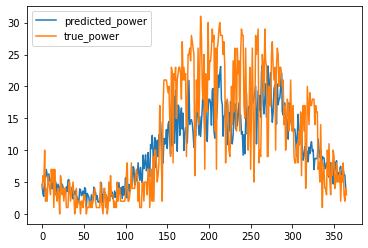

In [ ]:
y_predicted = x_input.reshape((x_input.shape[1]))
plt.plot(y_predicted, label='predicted_power')

y_true = X_valid.day_Power.values
plt.plot(y_true, label='true_power')
plt.legend()
plt.show()

In [ ]:
first_r2_score = r2_score(y_true[:-1], y_predicted) # Best possible score is 1.0 
first_mae = mean_absolute_error(y_true[:-1], y_predicted)
print('r2_score %.2f' % first_r2_score)
print('mae %.2f' % first_mae)

r2_score 0.56
mae 4.53


# Cumulation

In [ ]:
def cumulate(series, start=0):
    '''
    start is the starting cumulative power, the series is the daily solar power
    a list with daily cumulative power is the result
    '''
    cum = [start]
    for i in range(len(series)):
        sum_plus = cum[i] + series[i]
        cum.append(sum_plus)
    return cum

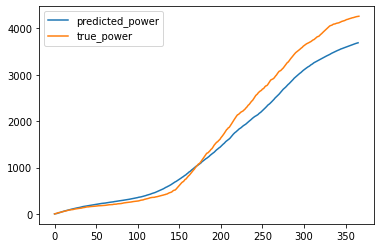

In [ ]:
y_true_cumulative = cumulate(y_true)
y_predicted_cumulative = cumulate(y_predicted)

plt.plot(y_predicted_cumulative, label='predicted_power')
plt.plot(y_true_cumulative, label='true_power')
plt.legend()
plt.show()

In [ ]:
true_cumulative_power_after_one_year = int(y_true_cumulative[-1])
predicted_cumulative_power_after_one_year = int(y_predicted_cumulative[-1])
print('true cumulative power after one year:', true_cumulative_power_after_one_year)
print('predicted cumulative power after one year:', predicted_cumulative_power_after_one_year)

acc_one_year = 1- (true_cumulative_power_after_one_year - predicted_cumulative_power_after_one_year)/true_cumulative_power_after_one_year
acc_one_year = acc_one_year * 100
print(len(y_true_cumulative), len(y_predicted_cumulative))
print('accuracy after one year: %.2f' %  acc_one_year,'%')
print('r2 score %.2f ' % r2_score(y_true_cumulative[:-1] , y_predicted_cumulative))
print('mae  %.2f' % mean_absolute_error(y_true_cumulative[:-1], y_predicted_cumulative))

true cumulative power after one year: 4260
predicted cumulative power after one year: 3688
367 366
accuracy after one year: 86.57 %
r2 score 0.95 
mae  250.04
